# CNN
---
- 가위(Rock), 바위(Paper) 보,(Scissors)
- 다중 분류(Multiclass Classification)

### tensorflow
- 텐서플로우 최신 버전 설치

In [1]:
# !pip install tensorflow==2.11.0

In [2]:
import tensorflow as tf

print(tf.__version__)

2.11.0


### 필요한 라이브러리 불러오기

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.get_logger().setLevel('ERROR')

print(tf.__version__)

2.11.0


In [4]:
import os
import shutil
import pathlib

### 데이터 준비
- rps dataset

In [30]:
# !pip install --upgrade --no-cache-dir gdown

In [32]:
# !gdown https://drive.google.com/uc?id=1dXD4MIzHgJ31xVGfDdBx0cgwZs1_W589

In [33]:
# !unzip rps.zip -d rps

In [8]:
# 불필요한 파일 제거: rps/rps-cv-images
remove_path = 'rps/rps-cv-images'
if os.path.exists(remove_path):
    shutil.rmtree(remove_path)

In [9]:
data_dir = pathlib.Path('rps')

In [10]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

2188

In [11]:
rps_list = os.listdir('rps')
for col in rps_list:
    print(col, len(list(data_dir.glob(f'{col}/*.png'))))

scissors 750
paper 712
rock 726
README_rpc-cv-images.txt 0


In [12]:
fnames = list(data_dir.glob('rock/*.png'))
fnames[0]

PosixPath('rps/rock/gtVEm7JEdr0wE1ip.png')

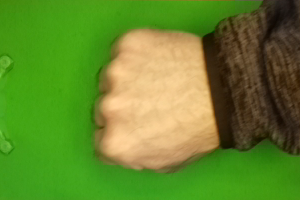

In [13]:
import PIL
import PIL.Image

PIL.Image.open(fnames[0])

**dataset 객체**
- 클래스: 3개
- 전체: 2188개 (training: 1751개, validation: 437개)

In [14]:
image_size = (200, 200)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset='training', 
    image_size=image_size, 
    batch_size=batch_size, 
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset='validation', 
    image_size=image_size, 
    batch_size=batch_size, 
    seed=42
)

Found 2188 files belonging to 3 classes.
Using 1751 files for training.
Found 2188 files belonging to 3 classes.
Using 437 files for validation.


In [15]:
train_ds.class_names

['paper', 'rock', 'scissors']

- 시각화

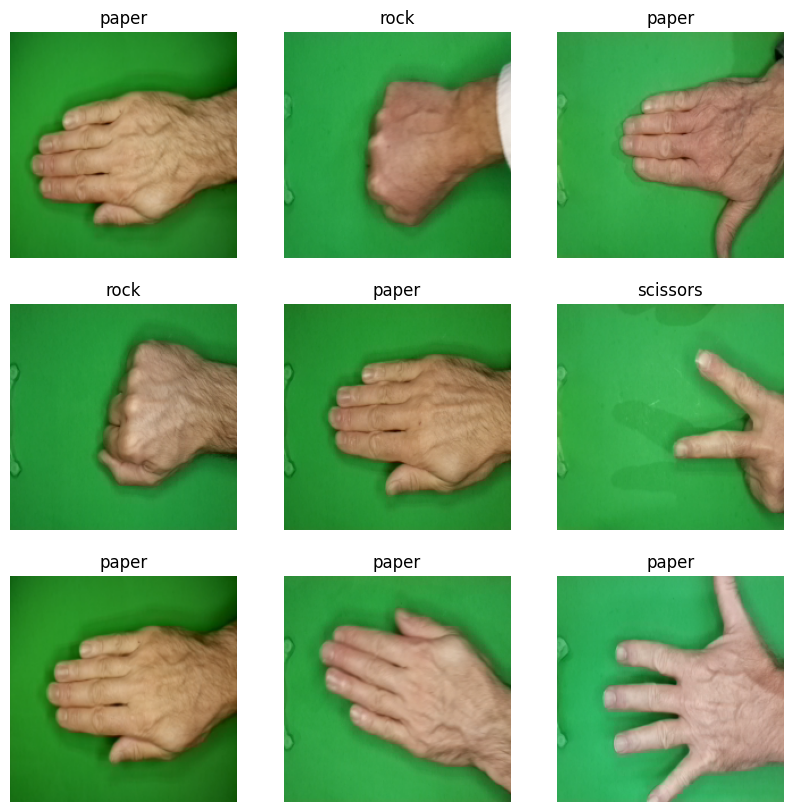

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('int'))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis('off')
plt.show()

**성능을 위한 설정**

In [17]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

**이미지 증강**

In [18]:
# 이미지 증강
data_augmen = keras.Sequential([
    layers.Rescaling(1./255.), 
    layers.Resizing(200, 200), 
    layers.RandomFlip('horizontal'), 
    layers.RandomFlip('vertical'), 
    layers.RandomRotation(0.5)
])

train_ds = train_ds.map(
    lambda img, label: (data_augmen(img), label), 
    num_parallel_calls = tf.data.AUTOTUNE
)

val_ds = val_ds.map(
    lambda img, label: (data_augmen(img), label), 
    num_parallel_calls = tf.data.AUTOTUNE
)

### 모델링(Modeling)

In [19]:
def build_model():
    model = keras.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=(200, 200, 3)), 
        layers.MaxPool2D(2), 
        layers.Conv2D(64, 3, activation='relu'), 
        layers.MaxPool2D(2), 
        layers.Flatten(), 
        layers.Dense(256, activation='relu'), 
        layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam', 
        loss='sparse_categorical_crossentropy', 
        metrics=['acc']
    )

    return model

In [20]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 147456)            0         
                                                                 
 dense (Dense)               (None, 256)              

### 학습(Training)

- ModelCheckpoint 콜백 적용

In [21]:
ckpt_path = './temp/my_best_model.ckpt'

ckpt_call = tf.keras.callbacks.ModelCheckpoint(ckpt_path, 
                                               monitor='val_loss', 
                                               save_best_only=True, 
                                               save_weights_only=True, 
                                               verbose=1)

In [22]:
EPOCHS = 10

history = model.fit(train_ds,
                    epochs=EPOCHS, 
                    validation_data=val_ds, 
                    callbacks=[ckpt_call], 
                    verbose=1)

Epoch 1/10
55/55 [==============================] - ETA: 0s - loss: 1.7963 - acc: 0.3998
Epoch 1: val_loss improved from inf to 0.96264, saving model to ./temp/my_best_model.ckpt
55/55 [==============================] - 211s 4s/step - loss: 1.7963 - acc: 0.3998 - val_loss: 0.9626 - val_acc: 0.5103
Epoch 2/10
55/55 [==============================] - ETA: 0s - loss: 0.9197 - acc: 0.5328
Epoch 2: val_loss improved from 0.96264 to 0.85879, saving model to ./temp/my_best_model.ckpt
55/55 [==============================] - 209s 4s/step - loss: 0.9197 - acc: 0.5328 - val_loss: 0.8588 - val_acc: 0.6568
Epoch 3/10
55/55 [==============================] - ETA: 0s - loss: 0.8183 - acc: 0.6259
Epoch 3: val_loss improved from 0.85879 to 0.82542, saving model to ./temp/my_best_model.ckpt
55/55 [==============================] - 196s 4s/step - loss: 0.8183 - acc: 0.6259 - val_loss: 0.8254 - val_acc: 0.6659
Epoch 4/10
55/55 [==============================] - ETA: 0s - loss: 0.6762 - acc: 0.7213
Epoch 

- 학습 과정 시각화

In [23]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16,8))
    
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'], label='Val Accuracy')
    plt.legend()

    plt.show()

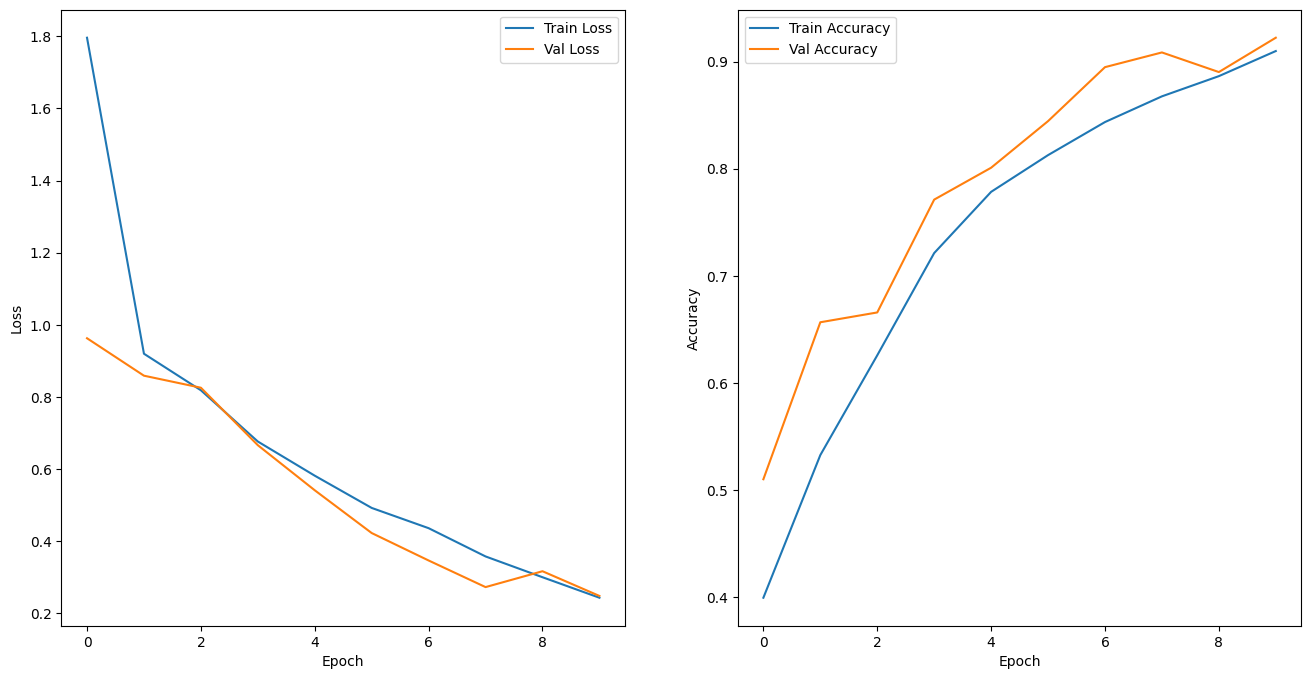

In [24]:
plot_history(history)

In [25]:
model.load_weights(ckpt_path)

### 평가(Evaluation)

In [26]:
model.evaluate(train_ds)

55/55 [==============================] - 49s 877ms/step - loss: 0.2352 - acc: 0.9166


[0.23516017198562622, 0.916619062423706]

- 모델 저장 및 확인

In [27]:
model.save('./model/model_soyeong.h5')

In [28]:
model = tf.keras.models.load_model('./model/model_soyeong.h5')

In [29]:
model.evaluate(train_ds)

55/55 [==============================] - 52s 936ms/step - loss: 0.2322 - acc: 0.9218


[0.23217231035232544, 0.9217590093612671]